# Real time predistortion demonstration

## Load PycQED

In [1]:
from pycqed.instrument_drivers.physical_instruments.ZurichInstruments import ZI_HDAWG8
from pycqed.measurement.kernel_functions_ZI import *

## Load libraries for plotting and fitting

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize

## Settings

In [3]:
CHANNEL = 1 # the channel on which to play the waveform

## Connect to the HDAWG device

Please replace 'dev8018' by the correct device identifier.

In [4]:
AWG8 = ZI_HDAWG8.ZI_HDAWG8('AWG8_8016', device='dev8016')

Connecting to server on host localhost:8004 using API level 5
Trying to connect to device dev8016
Connected to device dev8016 over 1GbE
Initialized awgModule
Initialized scopeModule
Connected to: ZurichInstruments HDAWG4 (serial:dev8016, firmware:54021) in 2.22s


## Upload SeqC program

In [5]:
AWG8.configure_awg_from_string(0, '''
// Constants
const FS = 2.4e9;
const PULSE_AMP = 0.5;
const PULSE_LENGTH = 5e-6;

// Waveform
wave w = join(PULSE_AMP*ones(PULSE_LENGTH*FS), zeros(PULSE_LENGTH*FS), -PULSE_AMP*ones(PULSE_LENGTH*FS), zeros(PULSE_LENGTH*FS));

while (1) {{
    // Play waveform on channel 1
    playWave({:d}, w);
    setTrigger(1);
    setTrigger(0);
}}   
'''.format(CHANNEL+1))

Configuring AWG_nr 0.
Compilation started
Detected 1 HDAWG sub-devices
Compiling string
Compilation successful
Uploading file to device...
File successfully uploaded in 1.42s


## Enable output channel 1

In [6]:
AWG8.set('sigouts_{:d}_on'.format(CHANNEL), 1)

## Start the AWG

In [7]:
AWG8.start()

## Run the real-time pre-distortion on channel 1

### High-pass filter compensation (HPC)

* Exponential decay is compensated by linear increase.
* Mapping from input $x_n$ to output $y_n$ for each sample with index $n$:
  * $y_n = x_n + k(2u_n-x_n)$.
* The state variable is $u_n = u_{n-8} + \bar{x}_n$, where $\bar{x}_n$ is an average over eight parallel paths. 
* Parameter $k = 1/(2\tau f_s$), where $\tau$ is the time constant and $f_s = 2.4\;\mathrm{GSa/s}$ is the sampling rate.
* Important: the state variable is only updated every 8th clock cycle of the sample clock, i.e with rate $f_s/8 = 300\;\mathrm{MSa/s}$


Set the time constant of the high-pass filter compensation:

In [8]:
AWG8.set('sigouts_{:d}_compensations_highpass_0_timeconstant'.format(CHANNEL), 10e-6)

Enable the high-pass filter compensations:

In [9]:
AWG8.set('sigouts_{:d}_compensations_highpass_0_enable'.format(CHANNEL), 1)

Check, whether the high-pass filter compensation overflowed (0 = no overflow, 1 = overflow detected):

In [10]:
AWG8.get('sigouts_{:d}_compensations_highpass_0_status'.format(CHANNEL))

0

Note: the overflow status will be cleared when disabling the HPC filter.

Disable real-time pre-distortion again:

In [11]:
AWG8.set('sigouts_{:d}_compensations_highpass_0_enable'.format(CHANNEL), 0)

### Exponential under- / overshoot compensation (EXP)
* Mapping from input $x_n$ to output $y_n$ for each sample with index $n$:
   * $y_n = (1 - k) x_n + k u_n$
* The state variable is an exponential moving average: $u_n = u_{n-32} + 32\alpha (\bar{x}_n - u_{n-32})$, where $\bar{x}_n$ is an average over 32 consecutive samples. 
* Important: the state variable is only updated every 8th clock cycle of the sample clock, i.e with rate $f_s/8 = 300\;\mathrm{MSa/s}$
* Parameters: 
 * $\alpha = 1 - e^{-1/(f_s\tau(1+A)}$
 * $k = \begin{cases}A/(1 + A - \alpha) & \text{, for } A\geq0\\ A/((1+A)(1-\alpha)) & \text{, for } A<0\end{cases}$
 * where $\tau$ is the time constant and $A$ the amplitude of the over- / undershoot relative to the pulse amplitude.

In [12]:
AWG8.set('sigouts_{:d}_compensations_exponentials_0_timeconstant'.format(CHANNEL), 1e-6)

In [13]:
AWG8.set('sigouts_{:d}_compensations_exponentials_0_amplitude'.format(CHANNEL), 0.25)

In [14]:
AWG8.set('sigouts_{:d}_compensations_exponentials_0_enable'.format(CHANNEL), 1)

### Multiple EXP filters

Here we activate an additional EXP filter with index 1:

In [15]:
AWG8.set('sigouts_{:d}_compensations_exponentials_1_timeconstant'.format(CHANNEL), 30e-9)

In [16]:
AWG8.get('sigouts_{:d}_compensations_exponentials_1_timeconstant'.format(CHANNEL))

3.0000144590758282e-08

In [17]:
AWG8.set('sigouts_{:d}_compensations_exponentials_1_amplitude'.format(CHANNEL), -0.15)

In [18]:
AWG8.set('sigouts_{:d}_compensations_exponentials_1_enable'.format(CHANNEL), 1)

Disable all EXP filters again:

In [19]:
AWG8.set('sigouts_{:d}_compensations_exponentials_0_enable'.format(CHANNEL), 0)
AWG8.set('sigouts_{:d}_compensations_exponentials_1_enable'.format(CHANNEL), 0)

## Bounce correction

In [20]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_delay'.format(CHANNEL), 11.1e-9)

In [21]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_amplitude'.format(CHANNEL), 0.286)

In [22]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_enable'.format(CHANNEL), 1)

Disable the bounce correction again:

In [23]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_enable'.format(CHANNEL), 0)

### Load measured bounce

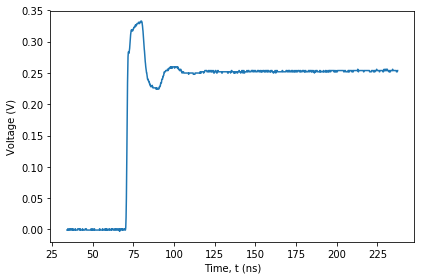

In [24]:
data = np.loadtxt('RefCurve_2018-07-05_0_125749.Wfm.csv', delimiter=';')
plt.plot(data[:,0]*1e9, data[:,1])
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

Determine scope sample rate:

In [25]:
scope_sample_rate = 1/(data[1,0]-data[0,0])

Define ideal step response

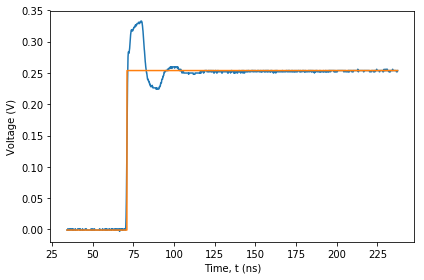

In [26]:
threshold = 0.15
step_response = data[0,1]*np.ones(len(data))
step_response[data[:,1] > threshold] = data[-1,1]

plt.plot(data[:,0]*1e9, data[:,1])
plt.plot(data[:,0]*1e9, step_response)
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

Fit correction:

In [27]:
bnds = ((0.4e-9, 103e-9), (-1, 1))

In [28]:
bnds[0][1]

1.03e-07

In [29]:
def objective_func(params):
    pred_corr = first_order_bounce_corr(data[:,1], min(max(params[0], bnds[0][0]), bnds[0][1]), params[1], 2.4e9, scope_sample_rate)
    step_response = pred_corr[0]*np.ones(len(pred_corr))
    step_response[pred_corr > threshold] = pred_corr[-1]
    penalty = 0 if bnds[0][0] < params[0] < bnds[0][1] else 10
    return np.mean(np.abs(pred_corr-step_response)) + penalty

In [30]:
opt = minimize(objective_func, (10e-9, 0.3), method='Nelder-Mead')

In [31]:
opt

 final_simplex: (array([[  1.11250000e-08,   2.75625000e-01],
       [  1.11545410e-08,   2.75570068e-01],
       [  1.11675415e-08,   2.75669861e-01]]), array([ 0.00260051,  0.00260052,  0.00260052]))
           fun: 0.0026005126780546265
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([  1.11250000e-08,   2.75625000e-01])

In [32]:
pred_corr = first_order_bounce_corr(data[:,1], opt.x[0], opt.x[1], 2.4e9, scope_sample_rate, sim_hw_delay = True)
step_response = pred_corr[0]*np.ones(len(pred_corr))
step_response[pred_corr > threshold] = pred_corr[-1]

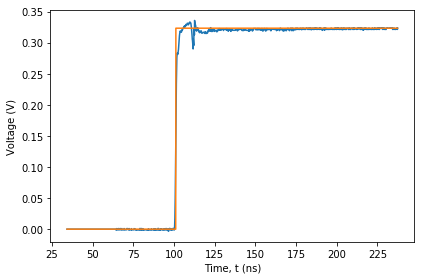

In [33]:
plt.plot(data[:,0]*1e9, pred_corr)
plt.plot(data[:,0]*1e9, step_response)
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()

plt.show()

### Run real-time pre-distortion with optimized coefficients

In [34]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_delay'.format(CHANNEL), opt.x[0])

In [35]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_amplitude'.format(CHANNEL), opt.x[1])

In [36]:
AWG8.set('sigouts_{:d}_compensations_bounces_0_enable'.format(CHANNEL), 0)

### Load measured correction and compare

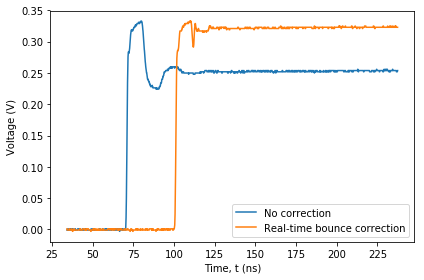

In [37]:
data_corr = np.loadtxt('RefCurve_2018-07-05_1_130234.Wfm.csv', delimiter=';')
plt.plot(data[:,0]*1e9, data[:,1], label='No correction')
plt.plot(data[:,0]*1e9, data_corr[:,1], label='Real-time bounce correction')
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()
plt.legend()
plt.savefig('bounce_correction_measurements.png',dpi=600,bbox_inches='tight')
plt.show()

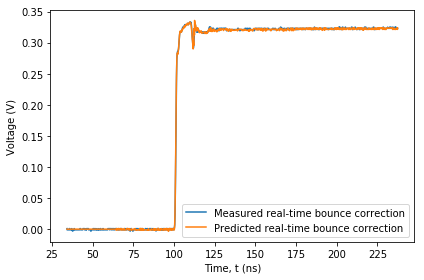

In [38]:
data_corr = np.loadtxt('RefCurve_2018-07-05_1_130234.Wfm.csv', delimiter=';')
#plt.plot(data[:,0]*1e9, data[:,1], label='No correction')
plt.plot(data[:,0]*1e9, data_corr[:,1], label='Measured real-time bounce correction')
plt.plot(data[:,0]*1e9, pred_corr, label='Predicted real-time bounce correction')
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.tight_layout()
plt.legend()
plt.savefig('bounce_correction_measurement_vs_prediction.png',dpi=600,bbox_inches='tight')
plt.show()

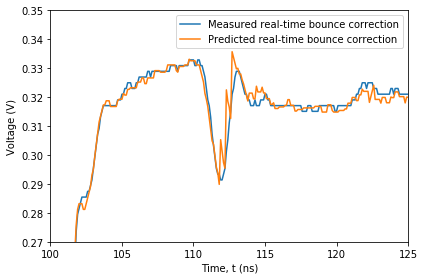

In [39]:
data_corr = np.loadtxt('RefCurve_2018-07-05_1_130234.Wfm.csv', delimiter=';')
#plt.plot(data[:,0]*1e9, data[:,1], label='No correction')
plt.plot(data[:,0]*1e9, data_corr[:,1], label='Measured real-time bounce correction')
plt.plot(data[:,0]*1e9, pred_corr, label='Predicted real-time bounce correction')
plt.xlabel('Time, t (ns)')
plt.ylabel('Voltage (V)')
plt.xlim([100, 125])
plt.ylim([0.27, 0.35])
plt.tight_layout()
plt.legend()
plt.savefig('bounce_correction_measurement_vs_prediction_zoom.png',dpi=600,bbox_inches='tight')
plt.show()

## Update parameter file

In [40]:
help(AWG8.create_parameter_file)

Help on method create_parameter_file in module pycqed.instrument_drivers.physical_instruments.ZurichInstruments.ZI_base_instrument:

create_parameter_file() method of pycqed.instrument_drivers.physical_instruments.ZurichInstruments.ZI_HDAWG8.ZI_HDAWG8 instance
    This generates a json file Containing the node_docs as extracted
    from the ZI instrument API.
    
    In the future this file (instead of the s_node_pars and d_node_pars)
    should be used to generate the drivers.



In [41]:
AWG8.create_parameter_file()